# Unsupervised Learning

By: Oscar Ko

This notebook was created for data analysis and unsupervised machine learning on this dataset from Stanford:

https://data.stanford.edu/hcmst2017

---
---

# Step 1: Imports and Data

Note: Train-Test split will not be done for unsupervised learning because this is for exploration and not testing models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("data/df_renamed.csv")

print(df.shape, "\n")

df.info(verbose=True)

(2844, 75) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2844 entries, 0 to 2843
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        2844 non-null   int64  
 1   ID                                2844 non-null   int64  
 2   ageGap                            2844 non-null   float64
 3   attendReligiousServiceFreq        2844 non-null   object 
 4   employmentStatus                  2844 non-null   object 
 5   genderSubjectAttractedTo          2837 non-null   object 
 6   houseType                         2844 non-null   object 
 7   householdAdults_num               2844 non-null   int64  
 8   householdIncome                   2844 non-null   int64  
 9   householdMinor_num                2844 non-null   int64  
 10  householdSize                     2844 non-null   int64  
 11  interracial                       2822 non-null   object

First drop the other two outcome labels, leaving just "relationshipQuality_isGood"

In [2]:
# Remove "relationshipQuality" and "relationshipQuality_num"

df = df.drop(["relationshipQuality", "relationshipQuality_num"], axis=1)

success1 = "relationshipQuality_num" not in df.columns
success2 = "relationshipQuality" not in df.columns

print("Sucessfully removed both columns?", success1 & success2)

Sucessfully removed both columns? True


### Remove unneeded columns

Columns related to couples first moving in together have over 300 missing values. This is due to not all couples moving in together. Since 300 is a large chunk of our 2275 records, I will remove these columns.

In [3]:
columns_to_remove = [
    "moveIn_YearFraction",
    "shipStart_to_moveIn_YearFraction",
    "Unnamed: 0", # Also Remove column with no useful info
    "ID" # Also Remove column with no useful info
]

df.drop(columns_to_remove, axis=1, inplace=True)


Since 183 records is not too much compared to the 2275 in total, I will op to remove these missing values.

In [4]:
# Dropping NA values


cols_with_na = df.columns[df.isna().any()].tolist()

for col in cols_with_na:

    indexes = df[col].notna()
    df = df[indexes]

# filter odd partner age cases
age_filter = df["partnerAge"] > 5
df = df[age_filter]



# Check number of rows with missing values
print("Cases with missing values:", df.isna().any(axis=1).sum())

Cases with missing values: 0


In [5]:
print(df.shape)

(2608, 69)


---
---

# Step 2: Prepare the Data for Machine Learning

### One-Hot Encode Categorical Features

In [6]:
# First get the numeric columns and the categorical columns

numeric_features = list(df._get_numeric_data().columns)

categorical_features = list(set(df.columns) - set(numeric_features))


# removing the label, so it doesn't get mistaken as numeric
numeric_features.remove('relationshipQuality_isGood') 


print(len(df.columns), len(numeric_features), len(categorical_features))

print(df.shape)

69 20 48
(2608, 69)


In [7]:
# One hot encode categorical features 

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print(df.shape)

(2608, 110)


### Feature Scaling on Numeric Columns with Standardization

In [8]:
# import scaling & column transformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Create a function to scale df

def scaleCategoricalFeatures(X_data):
    
    scaler = StandardScaler()

    X_data[numeric_features] = scaler.fit_transform(X_data[numeric_features])
    
    return X_data

df = scaleCategoricalFeatures(df)

print(df.shape)

(2608, 110)


### Make sure it worked by seeing if Standard Deviations of Numeric Columns are 1

In [9]:
df.describe()

,ageGap,householdAdults_num,householdIncome,householdMinor_num,householdSize,met_YearFraction,met_to_shipStart_diff,numRelativesSeePerMonth,partnerAge,partnerEduc_years,...,metThru_orAs_neighbors_yes,season_shipStart_spring,season_shipStart_summer,season_shipStart_winter,subjectGrewUpInUS_Refused,subjectGrewUpInUS_United States,metIn_voluntaryOrg_yes,metIn_military_yes,metOnline_chat_yes,metThru_family_yes
count,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,2.608000e+03,...,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000
mean,-1.911389e-17,5.295270e-16,4.729516e-17,2.354116e-16,9.970722e-16,-1.432647e-15,-6.055568e-17,-2.062086e-16,-1.873076e-16,3.171458e-17,...,0.059816,0.236196,0.276840,0.236963,0.000383,0.940184,0.059433,0.018788,0.011120,0.143021
std,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,...,0.237191,0.424826,0.447523,0.425301,0.019582,0.237191,0.236478,0.135803,0.104882,0.350162
min,-8.606632e-01,-1.377801e+00,-1.354838e+00,-5.494640e-01,-1.263476e+00,-3.276599e+00,-3.668050e-01,-6.828172e-01,-2.427833e+00,-5.721942e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.529444e-01,-2.279434e-01,-7.208737e-01,-5.494640e-01,-5.395865e-01,-7.646044e-01,-3.668050e-01,-6.828172e-01,-8.752847e-01,-8.948920e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.375067e-01,-2.279434e-01,-1.987858e-01,-5.494640e-01,-5.395865e-01,1.965890e-01,-3.284706e-01,-2.901409e-01,5.624415e-02,-9.038379e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.779309e-01,-2.279434e-01,6.589301e-01,4.547421e-01,9.081929e-01,8.555581e-01,-1.177716e-01,2.988737e-01,8.014672e-01,7.141245e-01,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,8.486684e+00,7.821058e+00,3.082910e+00,7.484184e+00,5.251531e+00,1.380740e+00,1.221991e+01,9.134092e+00,2.850831e+00,2.323141e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# just making sure the binary labels are still good

df[["relationshipQuality_isGood"]].describe()

,relationshipQuality_isGood
count,2608.000000
mean,0.912193
std,0.283068
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
# alphbetize column names

df = df.sort_index(axis=1)

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 0 to 2843
Data columns (total 110 columns):
 #    Column                                                                                        Dtype  
---   ------                                                                                        -----  
 0    ageGap                                                                                        float64
 1    attendReligiousServiceFreq_More than once a week                                              uint8  
 2    attendReligiousServiceFreq_Never                                                              uint8  
 3    attendReligiousServiceFreq_Once a week                                                        uint8  
 4    attendReligiousServiceFreq_Once a year or less                                                uint8  
 5    attendReligiousServiceFreq_Once or twice a month                                              uint8  
 6    attendReligiousService

---
---

# Step 3: Unsupervised Learning (ALL TOP FEATURES)

### Principal Component Analysis

#### Capture 95% of variance 

In [37]:
from sklearn.decomposition import PCA

classification_top_features = [
    "householdIncome",
    "isLivingTogether_Yes",
    "metAs_coworkers_yes",
    "partnerAge",
    "partnerMotherEduc_years",
    "sexFrequency_3 to 6 times a week",
    "sexFrequency_Once a month or less",
    "sexFrequency_Once or twice a week",
    "relationshipQuality_isGood"
]

regression_top_features = [    
    "householdIncome",
    "householdMinor_num",
    "isLivingTogether_Yes",
    "metAs_workNeighbors_yes",
    "metIn_school_yes",
    "partnerRace_Asian or Pacific Islander",
    "partnerRace_White",
    "sexFrequency_3 to 6 times a week",
    "sexFrequency_Once a month or less",
    "sexFrequency_Once or twice a week",
    "whoEarnedMore_We earned about the same amount",
    "relationshipQuality_isGood"
]

all_top_features = list(set(classification_top_features +
                           regression_top_features))

df_less = df.copy()[all_top_features]

# create instance of PCA with enough features to capture 95% of the variance
pca = PCA(n_components=0.95,
         random_state=42)

# fit PCA model to the scaled data
pca.fit(df_less)

print(len(all_top_features) - 1, "top features.\n")

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca.explained_variance_ratio_)

14 top features.

--------------------Explained variance ratio--------------------
[0.27020349 0.22196401 0.16417491 0.1117872  0.05204918 0.03086403
 0.030255   0.0272375  0.02142791 0.0196481  0.01752228]


#### How many features to retain 95% variance?

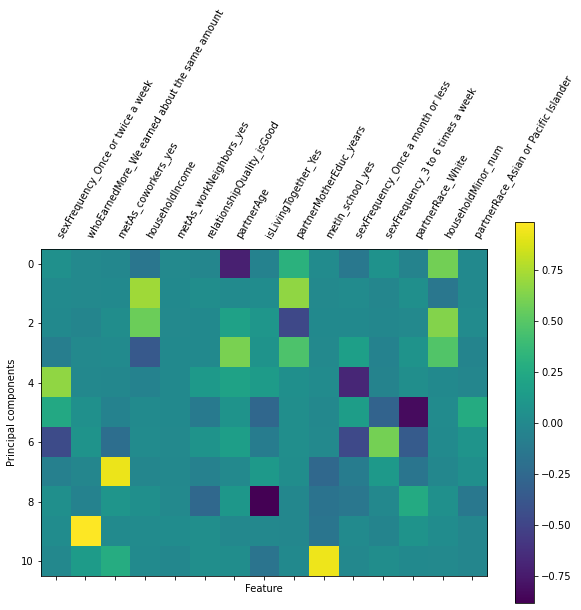

In [13]:
plt.figure(figsize=(10, 10))

plt.imshow(pca.components_, cmap='viridis')

plt.colorbar(location="right",
            shrink=0.7)

plt.xticks(range(len(df_less.columns)),
           df_less.columns, 
           rotation=60, 
           ha='left',
           va="bottom",
           y=1.05
          )

plt.xlabel("Feature")
plt.ylabel("Principal components")

plt.show()

#### NOTES:

##### Component 0:

Positive Signs

- Number of minors in household (strong)
- Partner's mother education (strong)

Negative Signs

- Partner's Age (strong)

#### Component 1:

Positive Signs

- Household income (strong)
- Partner's mother education (strong)

Negative Signs

- Numer of minors in household (moderate)

### K-Means Clustering: Elbow Method

In [16]:
df_less_pca = pca.transform(df_less)

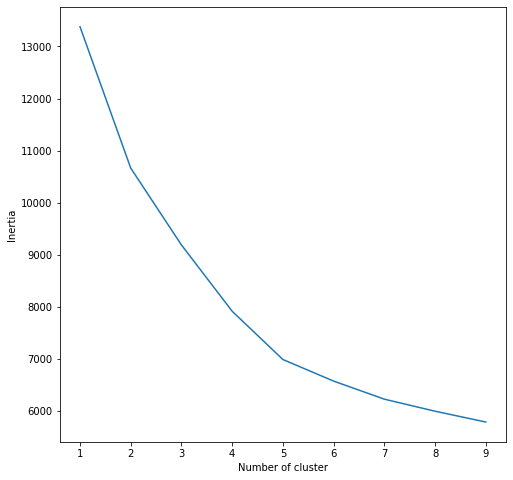

In [17]:
from sklearn.cluster import KMeans

inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(df_less_pca)
    inertiaVals[k] = kmeansTmp.inertia_ 
    
plt.figure(figsize=(8, 8))

plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))

plt.xlabel("Number of cluster")
plt.ylabel("Inertia")

plt.show()

With PCA

It seems the optimal number of clusters might be K = 5.

The curve goes from steep to shallow at K = 5, and afterwards, it smooths out.

### K-Means Clustering 

When I created a correlation matrix in Project 1, Glucose (r = 0.48) and BMI (r = 0.28) had the highest correlations with the diabetes outcome.

For visualizing K-Means without PCA, I will use Glucose and BMI.

Text(0, 0.5, 'Component 1')

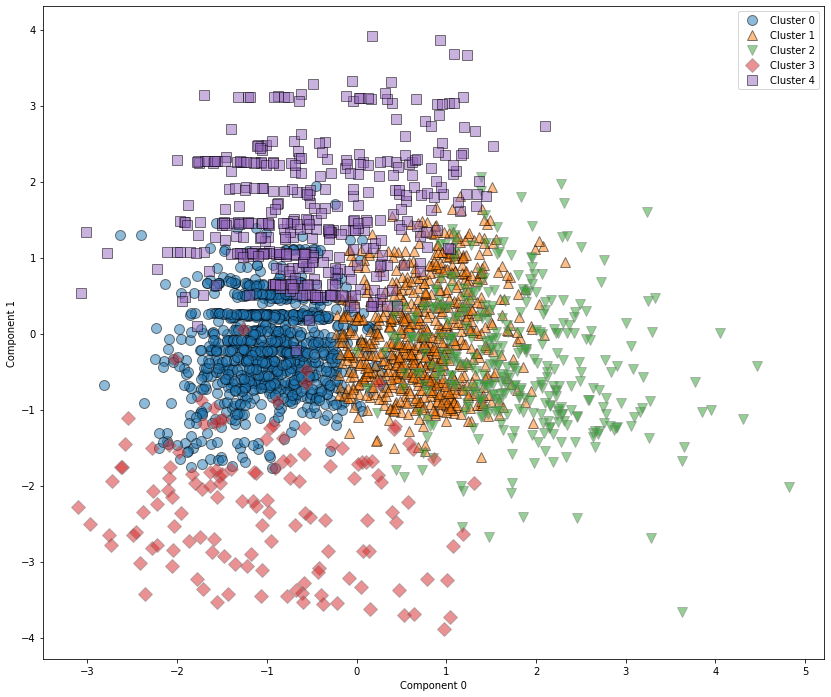

In [19]:
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=5,
               random_state=42)

kmeans.fit(df_less_pca)

assignments=kmeans.labels_


# Select X and Y Axis

X = "Component 0"
y = "Component 1"

plt.figure(figsize=(14, 12))

mglearn.discrete_scatter(
    df_less_pca[:,0],
    df_less_pca[:,1], 
    assignments,
    alpha=0.5
)


plt.legend([
    "Cluster 0",
    "Cluster 1",
    "Cluster 2",
    "Cluster 3",
    "Cluster 4",
    "Cluster 5"
], loc="best")

plt.xlabel(X)
plt.ylabel(y)

#### Component 0:

Positive Signs

- Number of minors in household (strong)
- Partner's mother education (moderate)

Negative Signs

- Partner's Age (strong)

#### Component 1:

Positive Signs

- Household income (strong)
- Partner's mother education (strong)

Negative Signs

- Number of minors in household (moderate)

---

#### Blue Circles - Cluster 0 

- Less minors in household
- Less educated partner mother
- Older partner age

(Older couples whose children have moved out?)

#### Orange Triangles - Cluster 1 

- Average/More minors in household
- Average/More educated partner mother
- Average/Younger partner age

(Average young couple family?)

#### Green Trangles - Cluster 2

- More minors in household
- Average/More educated partner mother
- Younger partner age

(Bigger young couple family?)

#### Red Diamonds - Cluster 3

- Average number of minors in household
- Much Less educated partner mother
- Older partner age
- Less HH income

(Poor older less educated with children?)

#### Purple Squares - Cluster 4

- Much less minors in household
- Average educated partner mother
- Older partner age
- Higher HH income

(Older wealthy couple with no kids)

### Visualize rQual

What can we learn about a subject's rating of their relationship quality by visualizing the first two PCA components?

Text(0, 0.5, 'Component 1')

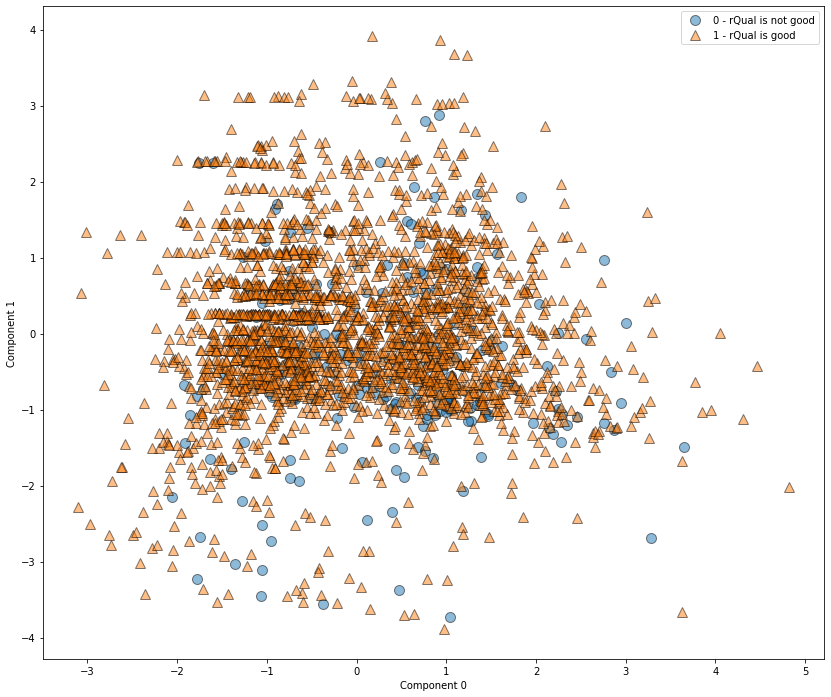

In [36]:
# visualize relationship quality 

rQual = np.array(df_less["relationshipQuality_isGood"])

# Select X and Y Axis

X = "Component 0"
y = "Component 1"

plt.figure(figsize=(14, 12))

mglearn.discrete_scatter(
    df_less_pca[:,0],
    df_less_pca[:,1], 
    rQual,
    alpha=0.5
)


plt.legend([
    "0 - rQual is not good",
    "1 - rQual is good"
], loc="best")

plt.xlabel(X)
plt.ylabel(y)

**NOTES:**

It seems subjects that rate their relationship less than "good," are scattered all over the plot.

But it does seem there are less blue circles at the far top area and far left area.

The far top area, according to the heatmap of Component 1, consists of couples that:

- Have less minors in their home
- Higher income
- Higher education

The far left area, according to the heatmap of Component 0, consists of couples that:

- Older age
- Have less minors in their home
- Slightly less education (probably because these are older couples.) 

---
---

# Conclusions

Component 0 and Component 1 account for a combined 49% of the variance of the top 14 features.

By analyzing the relationships of the features within these components, we might have some idea of how the top features behave, and possibly gain some insight into the relationships of this dataset.

According to Component 0, a subject's partner's age is negatively correlated with the number of children in one's household. It seems older couples are more likely to have more children at home, and younger couples have less.

- Are younger couples opting to not have as many children as their older counterparts?

- Maybe older couples had more time to accumulate children compared to their younger counterparts?


According to Component 1, a subject's household income is positively correlated with the partner's mother's education years. Since the education of the subject, the partner, and their mothers all have some correlation, it seems more education leads to more income in general. And since subjects tend to find partners of similar education level, it ends up doubling the income.

---

These are only two PCA components of only 15 features in the dataset, so the insights may not be exact, but it is likely that age, number of children, income, and education levels all have some connection to relationships (and possibly how a subject would self-rate their relationship quality).

Looking at the last plot, subjects that rated their relationship as "good" and not "good" are all over the plot, so it seems these top 14 features are still not all that great for predicting relationship quality.

That being said, it does seem that subjects who have more education, more income, older age, less minors in the home are slightly more likely to self-rate their relationships as "good" or higher.